In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy

In [3]:
from functools import partial

Uncertainty
========

Let's start by defining a FOPDT function as in the textbook

In [4]:
def G_P(k, theta, tau, s):
    """ Equation 7.19 """
    return k/(tau*s + 1)*numpy.exp(-theta*s)

Let's see what this looks like for particular values of $k$, $\tau$ and $\theta$

In [5]:
omega = numpy.logspace(-2, 2, 1000)
s = 1j*omega

In [6]:
Gnom = partial(G_P, 2.5, 2.5, 2.5)

In [7]:
def Gnom(s):
    return G_P(2.5, 2.5, 2.5, s)

In [8]:
Gfr = Gnom(s)

In [9]:
pomega = 0.5

In [10]:
def nominal_curve():
    plt.plot(Gfr.real, Gfr.imag)
    plt.axhline(0, color='black')
    plt.axvline(0, color='black')

In [11]:
def nominal_point(pomega):
    Gnomp = Gnom(1j*pomega)
    plt.scatter(Gnomp.real, Gnomp.imag, s=100, color='magenta')

In [12]:
Gnom(1j*pomega)

(-0.8496667432187457-1.310378119365534j)

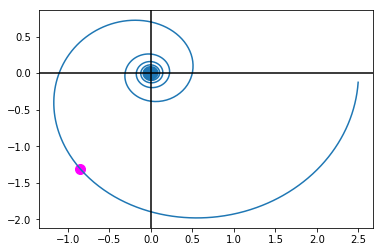

In [13]:
nominal_curve()
nominal_point(pomega)

At a particular frequency, let's look at a couple of possible plants

In [14]:
varrange = numpy.arange(2, 3, 0.1)
def cloudpoints(pomega):
    points = numpy.array([G_P(k, theta, tau, pomega*1j) 
                          for k in varrange 
                          for tau in varrange 
                          for theta in varrange])
    nominal_curve()
    nominal_point(pomega)
    plt.scatter(points.real, points.imag, color='red', alpha=0.1)

In [15]:
from ipywidgets import interact
import ipywidgets as widgets

In [16]:
interact(cloudpoints, pomega=(0.1, 10))

interactive(children=(FloatSlider(value=5.05, description='pomega', max=10.0, min=0.1), Output()), _dom_classes=('widget-interact',))

<function __main__.cloudpoints>

Let's try to approximate this region by a disc

In [17]:
Gnomp = Gnom(1j*pomega)
points = numpy.array([G_P(k, theta, tau, pomega*1j) 
                      for k in varrange 
                      for tau in varrange 
                      for theta in varrange])

radius = max(abs(P - Gnomp) for P in points)
radius

0.8068845952466887

In [18]:
def discapprox(pomega, radius):
    Gnomp = Gnom(1j*pomega)
    c = plt.Circle((Gnomp.real, Gnomp.imag), radius, alpha=0.2)
    cloudpoints(pomega)
    plt.gca().add_artist(c)
    plt.axis('equal')
interact(discapprox, pomega=(0.1, 5), radius=radius)

interactive(children=(FloatSlider(value=2.5500000000000003, description='pomega', max=5.0, min=0.1), FloatSlider(value=0.8068845952466887, description='radius', max=2.420653785740066, min=-0.8068845952466887), Output()), _dom_classes=('widget-interact',))

<function __main__.discapprox>

The above represents an _additive_ uncertainty description, 
$$ |\Delta_A| < 1 $$
$$ G_p(s) = G(s) + w_A(s)\Delta_A(s); \quad |\Delta_A(j\omega) | \leq 1 \forall \omega| (7.20)$$

In [19]:
Npoints = 10000
Delta_As = (numpy.random.rand(Npoints)*2-1 + 
            (numpy.random.rand(Npoints)*2 - 1)*1j)
valid_values = numpy.abs(Delta_As) < 1
Delta_As = Delta_As[valid_values]

(-1.1063694485352737,
 1.1038999552296844,
 -1.113657849726756,
 1.113285425459891)

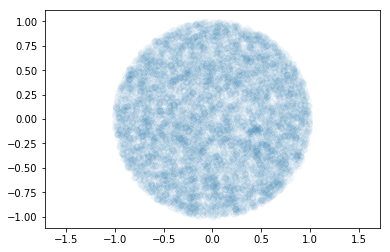

In [20]:
plt.scatter(Delta_As.real, Delta_As.imag, alpha=0.03)
plt.axis('equal')

In [21]:
def discapprox(pomega, radius):
    Gnomp = Gnom(1j*pomega)
    #c = plt.Circle((Gnomp.real, Gnomp.imag), radius, alpha=0.2)
    Gp_A = Gnomp + radius*Delta_As
    plt.scatter(Gp_A.real, Gp_A.imag, alpha=0.03)
    cloudpoints(pomega)
    #plt.gca().add_artist(c)
    plt.axis('equal')
interact(discapprox, pomega=(0.1, 5), radius=radius)

interactive(children=(FloatSlider(value=2.5500000000000003, description='pomega', max=5.0, min=0.1), FloatSlider(value=0.8068845952466887, description='radius', max=2.420653785740066, min=-0.8068845952466887), Output()), _dom_classes=('widget-interact',))

<function __main__.discapprox>

We now build frequency response for $\Pi$ (all possible plants).

In [22]:
Pi = numpy.array([G_P(k, theta, tau, s) 
                  for k in varrange 
                  for tau in varrange 
                  for theta in varrange])

In [23]:
deviations = numpy.abs(Pi - Gfr)

In [24]:
maxima = numpy.max(deviations, axis=0)

In [25]:
maxima.max()

0.8069129871622085

(0.01, 5.958602718540842)

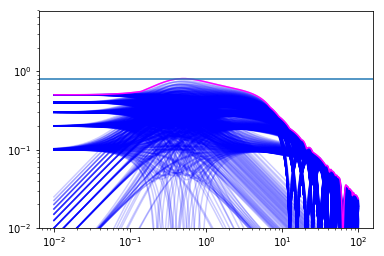

In [26]:
plt.loglog(omega, numpy.abs(deviations.T), color='blue', alpha=0.2);
plt.loglog(omega, maxima, color='magenta')
plt.axhline(radius)
#plt.loglog(pomega, radius, 'r.')
plt.ylim(ymin=1e-2)

Optimisation of the maximum
---------------------------

In [27]:
from scipy.optimize import minimize

In [28]:
def objective(x, omega):
    k, tau, theta = x
    s = 1j*omega
    return -numpy.abs(Gnom(s) - G_P(k, tau, theta, s))

In [29]:
objective([2.5, 2.5, 2.5], 0)

-0.0

In [30]:
x0 = numpy.array([2.5, 2.5, 2.5])
bounds = [[2, 3]]*3
minimize(objective, x0, args=0, bounds=bounds)

      fun: -0.5
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.99999999,  0.        ,  0.        ])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 8
      nit: 1
   status: 0
  success: True
        x: array([3. , 2.5, 2.5])

In [31]:
vals = []
starts = 10
for omegai in omega:
    best = float('-inf')
    # We will use "multi-start" strategy
    for start in range(starts):
        x0 = numpy.random.uniform(2, 3, size=3)
        r = minimize(objective, 
                     x0, 
                     args=omegai, 
                     bounds=bounds,
                     method='TNC')  # TNC and L-BFGS-B can handle bounds
        if -r['fun'] > best:
            best = -r['fun']
    vals.append(best)

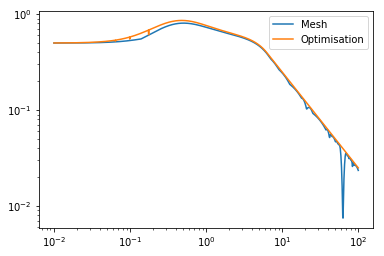

In [32]:
plt.loglog(omega, maxima, label='Mesh')
plt.loglog(omega, vals, label='Optimisation')
plt.legend()

In [33]:
def plot_upper(K, tau, plotmax):
    w_A = K/(tau*s + 1)
    if plotmax:
        plt.loglog(omega, maxima, color='blue')
    else:
        plt.loglog(omega, numpy.abs(deviations.T), color='blue', alpha=0.1);
    plt.loglog(omega, numpy.abs(w_A), color='red')
    plt.ylim(ymin=1e-2)

In [34]:
i = interact(plot_upper, K=(0.1, 2, 0.01), tau=(0.01, 1, 0.01), 
             plotmax=widgets.Checkbox())

interactive(children=(FloatSlider(value=1.05, description='K', max=2.0, min=0.1, step=0.01), FloatSlider(value=0.5, description='tau', max=1.0, min=0.01, step=0.01), Checkbox(value=False, description='plotmax'), Output()), _dom_classes=('widget-interact',))

In [35]:
def combined(pomega, K, tau, plotmax):
    f = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plot_upper(K, tau, plotmax)
    plt.axvline(pomega)
    plt.subplot(1, 2, 2)
    s = 1j*pomega
    radius = numpy.abs(K/(tau*s + 1))
    discapprox(pomega, radius)

In [36]:
interact(combined, pomega=(0.1, 10), K=(0.1, 2, 0.01), tau=(0.01, 1, 0.01), 
         plotmax=widgets.Checkbox())

interactive(children=(FloatSlider(value=5.05, description='pomega', max=10.0, min=0.1), FloatSlider(value=1.05, description='K', max=2.0, min=0.1, step=0.01), FloatSlider(value=0.5, description='tau', max=1.0, min=0.01, step=0.01), Checkbox(value=False, description='plotmax'), Output()), _dom_classes=('widget-interact',))

<function __main__.combined>

## Addednum: understanding the use of partial

In the code above we used the function `functools.partial`. What's going on there?

Let's say we have a function with many arguments, but we want to optimise only one:

In [37]:
def function_with_many_arguments(a, b, c, d):
    return 1*a + 2*b + 3*c + 4*d

We could define a "wrapper" which just calls that function with the single argument we need.

In [38]:
def wrapper_function(d):
    return function_with_many_arguments(1, 2, 3, d)

In [39]:
wrapper_function(2)

22

In [40]:
import scipy.optimize

In [41]:
scipy.optimize.fsolve(wrapper_function, 3)

array([-3.5])

`functools.partial` automates the creation of this wrapper function.

In [42]:
from functools import partial

In [43]:
wrapper_function = partial(function_with_many_arguments, 1, 2, 3)

In [44]:
wrapper_function(2)

22

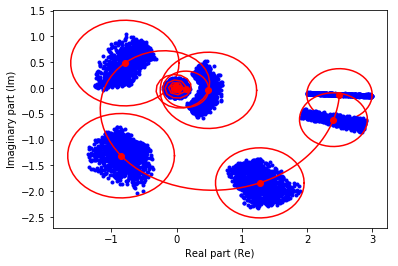

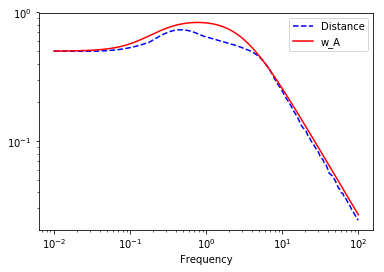

In [46]:
import numpy as np
import matplotlib.pyplot as plt

def G_P(k, tau, theta, s):
    return k/(tau*s + 1)*np.exp(-theta*s)

def G(s):
    return G_P(2.5, 2.5, 2.5, s)

def w_A(s):
    k = 0.5
    tau1 = 1/0.14
    tau2 = 1/0.25
    tau3 = 1/3.0
    return k*(tau1*s + 1)/(tau2*s + 1)/(tau3*s + 1)

def circle(centerx, centery, radius):
    angle = np.linspace(0, 2*np.pi)
    x = centerx + np.cos(angle)*radius
    y = centery + np.sin(angle)*radius
    plt.plot(x, y, 'r-')

def randomparameters():
    return [2 + np.random.rand() for i in range(3)]

N = 1000

for omega in [0.01, 0.05, 0.2, 0.5, 1, 2, 7]:
    s = omega * 1j
    frn = G(s)
    r = abs(w_A(s))

    for i in range(N):
        k, tau, theta = randomparameters()
        frp = G_P(k, tau, theta, s)
        plt.plot(np.real(frp), np.imag(frp), 'b.')

    plt.plot(np.real(frn), np.imag(frn), 'ro')
    circle(np.real(frn), np.imag(frn), r)

omega = np.logspace(-2, 2, 200)
s = omega*1j
fr = G_P(2.5, 2.5, 2.5, s)
plt.plot(np.real(fr), np.imag(fr), 'r-')
plt.xlabel('Real part (Re)')
plt.ylabel('Imaginary part (Im)')


plt.figure(2)
frn = G(s)
distance = np.zeros_like(omega)
for i in range(N):
    k, tau, theta = randomparameters()
    frp = G_P(k, tau, theta, s)
    distance = np.maximum(abs(frp - frn), distance)

plt.loglog(omega, distance, 'b--')
plt.loglog(omega, list(map(abs, w_A(s))), 'r')
plt.xlabel('Frequency')
plt.legend(['Distance','w_A'])

plt.show()